## GET DATA & TO CSV

In [28]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

user = 'postgres'
password = '1711'
host = 'localhost'
port = '5432'
database = 'Full_Data'
schema = 'us_stock'
table = 'nasdaq100'
conn = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'                                           
engine = create_engine(conn)

query = f"SELECT * FROM {schema}.{table}"
df = pd.read_sql(query, engine)
df['date'] = pd.to_datetime(df['date']).dt.date
df.set_index('date', inplace=True)
df.head()

,open,high,low,close,adjusted_close,volume,ticker
date,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.844981,535796800,AAPL
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.773741,512377600,AAPL
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.785063,778321600,AAPL
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.717125,767972800,AAPL
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.751094,460734400,AAPL


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501350 entries, 2000-01-03 to 2024-07-31
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   open            501350 non-null  float64
 1   high            501350 non-null  float64
 2   low             501350 non-null  float64
 3   close           501350 non-null  float64
 4   adjusted_close  501350 non-null  float64
 5   volume          501350 non-null  int64  
 6   ticker          501350 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 30.6+ MB


In [30]:
metrics = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']
matrices = {metric: df.pivot_table(index=df.index, columns='ticker', values=metric) for metric in metrics}

open_matrix = matrices['open'].fillna(0)
high_matrix = matrices['high'].fillna(0)
low_matrix = matrices['low'].fillna(0)
close_matrix = matrices['close'].fillna(0)
adjusted_close_matrix = matrices['adjusted_close'].fillna(0)
volume_matrix = matrices['volume'].fillna(0)

In [34]:
open_matrix.to_csv('open.csv')
high_matrix.to_csv('high.csv')
low_matrix.to_csv('low.csv')
close_matrix.to_csv('close.csv')
adjusted_close_matrix.to_csv('adjusted_close.csv')
volume_matrix.to_csv('volume.csv')

## IMPORT DATA

In [1]:
import glob
import os
import pandas as pd
import numpy as np

In [2]:
folder_path = r'D:\github\a1phas\stock\nasdaq\data'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
dataframes = {}

for file in csv_files:
    df_name = os.path.splitext(os.path.basename(file))[0]
    dataframes[df_name] = pd.read_csv(file)
                                   

In [3]:
matrices = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']
for i in matrices:
    df = dataframes[i]
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    globals()[i] = df

In [5]:
for i in matrices:
    df = globals()[i]
    
    train_df = df.iloc[:-756]
    test_df = df.iloc[-756:]
    
    globals()[f'{i}_train'] = train_df
    globals()[f'{i}_test'] = test_df


In [8]:
def alpha_signal(close_df, delta_window=5):
    alpha_df = pd.DataFrame(index=close_df.index, columns=close_df.columns)
    
    for col in close_df.columns:
        delta_close = close_df[col].diff()
        ts_min = delta_close.rolling(window=delta_window).min()
        ts_max = delta_close.rolling(window=delta_window).max()
        
        alpha_df[col] = np.where(
            ts_min > 0, 
            delta_close, 
            np.where(ts_max < 0, delta_close, -delta_close)
        )
    
    return alpha_df

In [115]:
def orders(df, delta_window=5):
    ords = pd.DataFrame(0, index=df.index, columns=df.columns)
    alpha_df = alpha_signal(df, delta_window=delta_window)
    for col in df.columns:
        last_order = 0
        holding_period = 0
        days_since_last_sell = 0
        for i in range(1, len(df)):
            if df[col].iloc[i - 1] > 0 and df[col].iloc[i] > 0:
                bull = alpha_df[col].iloc[i - 1] > 0
                bear = alpha_df[col].iloc[i - 1] < 0
                
                # print(f"Index {i}, Col {col}, Bull {bull}, Bear {bear}, Last Order {last_order}, Holding Period {holding_period}, Days Since Last Sell {days_since_last_sell}")
                
                if bull:
                    ords[col].iloc[i] = 1
                elif bear:
                    ords[col].iloc[i] = -1
                else:
                        ords[col].iloc[i] = 0
                     

    return ords

In [116]:
def perf_metrics(daily_pnl_series):
    sharpe = daily_pnl_series.mean() / daily_pnl_series.std() * np.sqrt(252)
    cum_ret = daily_pnl_series.cumsum()
    running_max = cum_ret.cummax()
    drawdown = running_max - cum_ret
    max_dd = (drawdown.max() / cum_ret.max()) * 100
    return sharpe, max_dd

Sharpe ratio: -0.17
Max drawdown: 200.33%


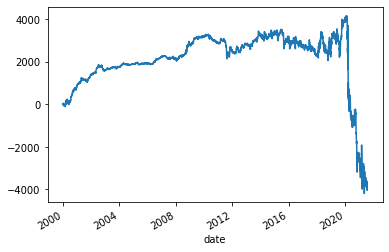

In [117]:
order_matrix = orders(close_train)
pnl_matrix = order_matrix.shift() * close_train.diff()
universe_pnl = pnl_matrix.sum(axis=1)
universe_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(universe_pnl)
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2f}%")

In [5]:
import investpy

# List all available bonds for Vietnam
bonds = investpy.get_bonds(country='Vietnam')
print(bonds)

   country         name        full_name
0  vietnam  Vietnam 10Y  Vietnam 10-Year
1  vietnam  Vietnam 15Y  Vietnam 15 Year
2  vietnam   Vietnam 7Y   Vietnam 7-Year
3  vietnam  Vietnam 20Y  Vietnam 20 Year
4  vietnam   Vietnam 3Y   Vietnam 3-Year
5  vietnam   Vietnam 2Y   Vietnam 2-Year
6  vietnam   Vietnam 1Y   Vietnam 1-Year
7  vietnam   Vietnam 5Y   Vietnam 5-Year
8  vietnam  Vietnam 25Y  Vietnam 25 Year


In [9]:
import investpy

# Define the correct bond name
bond = 'Vietnam 2Y'  # Example name; adjust based on the list

# Fetch historical data
data = investpy.get_bond_historical_data(bond=bond,
                                         from_date='01/01/2000',
                                         to_date='01/08/2024')

# # Save to a CSV file
# data.to_csv('vietnam_2_year_bond_yield_investpy.csv', index=False)

# print('Data saved to vietnam_2_year_bond_yield_investpy.csv')
data

,Open,High,Low,Close
Date,,,,
2007-07-04,7.100,7.100,7.100,7.100
2007-07-09,7.100,7.100,7.100,7.100
2007-07-10,7.150,7.150,7.150,7.150
2007-07-11,7.150,7.150,7.150,7.150
2007-07-12,7.100,7.100,7.100,7.100
...,...,...,...,...
2024-07-26,2.033,2.033,2.033,2.033
2024-07-29,2.033,2.033,2.033,2.033
2024-07-30,2.033,2.033,2.033,2.033
